# Figure 2: Transitional effects of asynchronous Travel Rule adoption

This notebook reproduces **Figure 2** in the paper  
*“Asynchronous Implementation of the Travel Rule and Transitional Risks in Crypto-Asset Regulation.”*

## Purpose
The notebook simulates a discrete-time agent-based model to compare three regulatory scenarios:

- **S**: Synchronized adoption of the Travel Rule  
- **A**: Asynchronous adoption across jurisdictions  
- **A′**: Asynchronous adoption with limited post-adoption implementation capacity (“paper compliance”)

The figure reports:
1. The number of successful illicit transactions  
2. The detection rate  
3. The distribution of transaction channels over time (Scenario A)

## Output
Running all cells generates `Figure2.png`, corresponding exactly to Figure 2 in the paper.

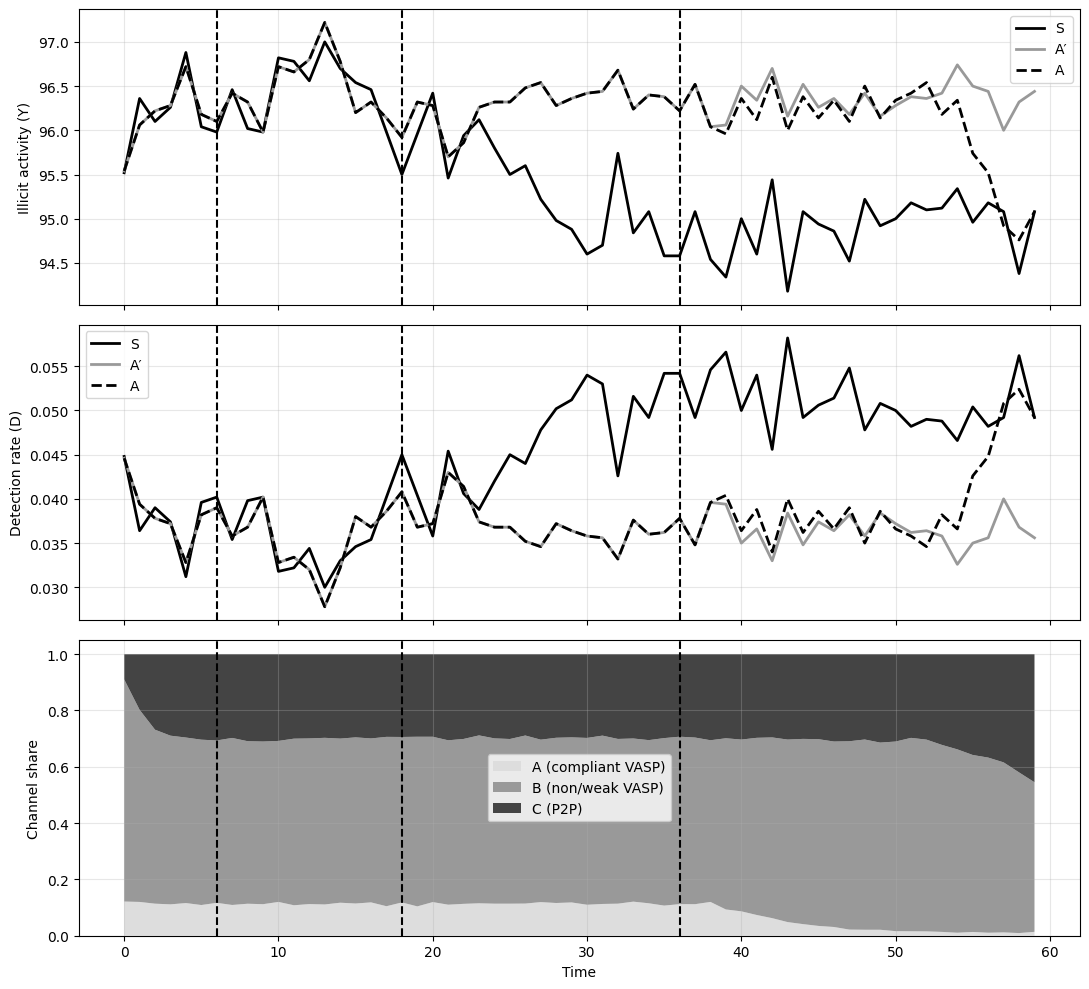

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Parsimonious ABM v0.5 (FINAL, visualization fixed)
# ============================================================

# ----------------------------
# Scenario definitions
# ----------------------------
def scenario_params(scenario):
    if scenario == "S":      # synchronized
        Tj = np.array([6, 6, 6, 6, 6, 6])
        rho = np.array([0.06, 0.06, 0.05, 0.05, 0.04, 0.04])
    elif scenario == "A":    # asynchronous
        Tj = np.array([6, 6, 18, 18, 36, 36])
        rho = np.array([0.06, 0.06, 0.05, 0.05, 0.04, 0.04])
    elif scenario == "Aprime":  # asynchronous + paper compliance
        Tj = np.array([6, 6, 18, 18, 36, 36])
        rho = np.array([0.06, 0.06, 0.05, 0.05, 0.015, 0.015])
    else:
        raise ValueError("Unknown scenario")
    return Tj, rho


# ----------------------------
# Cross-border weights
# ----------------------------
def compute_pair_weights(J=6):
    w = np.zeros((J, J))
    weights = {}

    def add(j, k, val):
        weights[(j, k)] = val

    core = [0, 1]
    mid = [2, 3]
    lag = [4, 5]

    add(0, 1, 3.0)
    for j in core:
        for k in mid:
            add(min(j, k), max(j, k), 2.0)
        for k in lag:
            add(min(j, k), max(j, k), 2.0)
    add(2, 3, 1.0)
    for j in mid:
        for k in lag:
            add(min(j, k), max(j, k), 1.0)
    add(4, 5, 0.5)

    total = sum(weights.values())
    for (j, k), val in weights.items():
        w[j, k] = val / total
        w[k, j] = w[j, k]
    return w


def compute_X(L, R, w):
    X = 0.0
    J = len(L)
    for j in range(J):
        for k in range(j + 1, J):
            if L[j] == 1 and L[k] == 1:
                X += w[j, k] * min(R[j], R[k])
    return np.clip(X, 0.0, 1.0)


# ----------------------------
# Choice rule
# ----------------------------
def logit_choice(costs, lam, rng):
    vals = -lam * np.array(costs)
    vals -= vals.max()
    probs = np.exp(vals)
    probs /= probs.sum()
    return rng.choice(3, p=probs)  # 0=A,1=B,2=C


# ----------------------------
# One simulation run
# ----------------------------
def run_one(
    scenario,
    seed,
    *,
    T=60,
    N=100,
    J=6,
    pi_cross=0.35,
    lam=5.0,
    pA0=0.18,
    pB0=0.08,
    pC0=0.02,
    a_s=0.40,
    b_s=0.50,
    F=6.0,
    kA=0.20,
    kB=0.05,
    kC_base=0.80,
    kC_min=0.02,
    kappa=0.10,
):
    rng = np.random.default_rng(seed)

    L = np.zeros(J)
    R = np.zeros(J)
    Tj, rho = scenario_params(scenario)
    w = compute_pair_weights(J)

    Y = np.zeros(T)
    D = np.zeros(T)
    sA = np.zeros(T)
    sB = np.zeros(T)
    sC = np.zeros(T)

    N_C_prev = 0

    for t in range(T):
        for j in range(J):
            if t >= Tj[j]:
                L[j] = 1
                R[j] = min(1.0, R[j] + rho[j])

        s_gap = 1.0 - compute_X(L, R, w)

        kC = max(kC_min, kC_base - kappa * np.log(1 + N_C_prev))

        cross = rng.random(N) < pi_cross

        pA = np.clip(pA0 - a_s * s_gap * cross, 0, 1)
        pB = np.clip(pB0 - b_s * s_gap * cross, 0, 1)
        pC = np.full(N, pC0)

        costA = pA * F + kA
        costB = pB * F + kB
        costC = pC * F + kC

        choices = np.zeros(N, dtype=int)
        for i in range(N):
            choices[i] = logit_choice(
                [costA[i], costB[i], costC[i]], lam, rng
            )

        p_true = np.where(choices == 0, pA,
                 np.where(choices == 1, pB, pC))
        caught = rng.random(N) < p_true

        Y[t] = N - caught.sum()
        D[t] = caught.mean()
        sA[t] = np.mean(choices == 0)
        sB[t] = np.mean(choices == 1)
        sC[t] = np.mean(choices == 2)

        N_C_prev = int(round(sC[t] * N))

    return Y, D, sA, sB, sC


# ----------------------------
# Monte Carlo wrapper
# ----------------------------
def run_all(Rruns=50, T=60, N=100):
    results = {}
    for scenario in ["S", "A", "Aprime"]:
        out = {
            "Y": np.zeros((Rruns, T)),
            "D": np.zeros((Rruns, T)),
            "share_A": np.zeros((Rruns, T)),
            "share_B": np.zeros((Rruns, T)),
            "share_C": np.zeros((Rruns, T)),
        }
        for r in range(Rruns):
            Y, D, sA, sB, sC = run_one(
                scenario,
                seed=1000 * r + (0 if scenario == "S" else 10000),
                T=T,
                N=N,
            )
            out["Y"][r] = Y
            out["D"][r] = D
            out["share_A"][r] = sA
            out["share_B"][r] = sB
            out["share_C"][r] = sC
        results[scenario] = out
    return results


# ----------------------------
# Plotting (Figure 2 FINAL – grayscale)
# ----------------------------
def plot_mean(ax, t, x, label, linestyle="-", color="black"):
    ax.plot(
        t,
        x.mean(axis=0),
        label=label,
        linewidth=2,
        linestyle=linestyle,
        color=color,
    )

def make_figure2(results, T=60):
    t = np.arange(T)
    fig, axs = plt.subplots(3, 1, figsize=(11, 10), sharex=True)

    # ---- Panel A: Illicit activity ----
    plot_mean(axs[0], t, results["S"]["Y"], "S", "-", "black")
    plot_mean(axs[0], t, results["Aprime"]["Y"], "A′", "-", "0.6")  # gray solid
    plot_mean(axs[0], t, results["A"]["Y"], "A", "--", "black")
    axs[0].set_ylabel("Illicit activity (Y)")

    # ---- Panel B: Detection rate ----
    plot_mean(axs[1], t, results["S"]["D"], "S", "-", "black")
    plot_mean(axs[1], t, results["Aprime"]["D"], "A′", "-", "0.6")  # gray solid
    plot_mean(axs[1], t, results["A"]["D"], "A", "--", "black")
    axs[1].set_ylabel("Detection rate (D)")

    # ---- Panel C: Channel shares (Scenario A) ----
    A = results["A"]
    axs[2].stackplot(
        t,
        A["share_A"].mean(axis=0),
        A["share_B"].mean(axis=0),
        A["share_C"].mean(axis=0),
        labels=["A (compliant VASP)", "B (non/weak VASP)", "C (P2P)"],
        colors=["#dddddd", "#999999", "#444444"],  # light → dark gray
    )
    axs[2].set_ylabel("Channel share")
    axs[2].set_xlabel("Time")

    # Vertical lines: adoption timing (Scenario A)
    Tj, _ = scenario_params("A")
    for ax in axs:
        ax.axvline(Tj[0], linestyle="--", color="black")
        ax.axvline(Tj[2], linestyle="--", color="black")
        ax.axvline(Tj[4], linestyle="--", color="black")
        ax.grid(alpha=0.3)

    for ax in axs:
        ax.legend()

    plt.tight_layout()
    return fig


# ----------------------------
# Run
# ----------------------------
if __name__ == "__main__":
    T = 60
    N = 100
    Rruns = 50  # increase to 100–300 for final submission

    results = run_all(Rruns=Rruns, T=T, N=N)
    fig = make_figure2(results, T=T)

    plt.show()
    fig.savefig("Figure2.png", dpi=200)
